In [1]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import StateGraph,START,END
from langchain_core.tools import tool
from typing import TypedDict,Annotated
from langgraph.prebuilt import ToolNode,tools_condition
from langchain_core.messages import HumanMessage,BaseMessage
from langgraph.graph.message import add_messages
from dotenv import load_dotenv
from langchain_core.messages import HumanMessage,AIMessage,SystemMessage,ToolMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.types import Command


In [2]:
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
import logging
logging.basicConfig(level=logging.DEBUG)


In [4]:
from langgraph.config import get_stream_writer

In [5]:
# web search tool 
from langchain_tavily import TavilySearch
web_search_tool = TavilySearch(max_results=3)

In [6]:
# File management tool
from langchain_community.agent_toolkits import FileManagementToolkit

working_directory = './'

file_management_tools =FileManagementToolkit(
    root_dir=str(working_directory),
    selected_tools=["read_file", "write_file", "list_directory"]
).get_tools()


read_tool, write_tool, list_tool = file_management_tools

In [7]:
from langchain_core.tools import BaseTool,tool
from langgraph.prebuilt.interrupt import HumanInterruptConfig,HumanInterrupt
from langchain_core.runnables import RunnableConfig
from langgraph.types import interrupt

In [8]:
def add_human_in_the_loop(toolhitl,interrupt_config: HumanInterruptConfig = None) -> BaseTool:
    """Wrap a tool to support human-in-the-loop review."""

    if not isinstance(toolhitl, BaseTool):
        toolhitl = tool(toolhitl)

    if interrupt_config is None:
        interrupt_config = {
            "allow_accept":True,
            "allow_edit": True,
            "allow_respond":True
        }

    @tool(toolhitl.name,description=toolhitl.description,args_schema=toolhitl.args_schema)
    def call_tool_with_interrupt(config: RunnableConfig, **tool_input):
        request: HumanInterrupt = {
            'action_request':{
                "action":toolhitl.name,
                "args":tool_input
            },
            "config":interrupt_config,
            "description": "Please review the tool call"
        }

        response = interrupt([request])[0]

        # approve the tool call
        if response["type"] == "accept":
            tool_response = toolhitl.invoke(tool_input, config)
        # update tool call args
        elif response["type"] == "edit":
            tool_input = response["args"]["args"]
            tool_response = toolhitl.invoke(tool_input, config)
        # respond to the LLM with user feedback
        elif response["type"] == "response":
            user_feedback = response["args"]
            tool_response = user_feedback
        else:
            raise ValueError(f"Unsupported interrupt response type: {response['type']}")

        return tool_response
    
    return call_tool_with_interrupt




In [9]:
#arxiv
import arxiv

@tool("arxiv_search")
def arxiv_search(query: str,max_results: int = 5) -> str:
    """
    Searches arXiv for papers matching the query.
    - query: keywords, authors or title
    - max_results: number of papers to return
    """
    try:
        writer = get_stream_writer()
        writer(f"Looking up research papers for topic : {query}")
        search = arxiv.Search(
            query=query,
            max_results=max_results,
            sort_by=arxiv.SortCriterion.Relevance
        )
        papers = []
        for result in search.results():
            pdf_url = result.pdf_url if hasattr(result,"pdf_url") else result.entry_id.replace("abs","pdf")
            papers.append(
                f"Title: {result.title}\n"
                f"Authors: {','.join(a.name for a in result.authors)}\n"
                f'Published: {result.published.date()}\n'
                f"Abstract: {result.summary.strip()}\n"
                f"Link: {result.entry_id}\n"
                f"PDF: {pdf_url}\n"
                + "-"*80

            )
        if not papers:
            return f"No results found for '{query}"
        writer(f"Acquired research papers for topic: {query}")
        return "\n".join(papers)
    except Exception as e:
        return f"Error during arXiv search: {e}"
    



In [10]:
#wikipedia
from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper
wikipedia_tool = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper(load_all_available_meta=True))

In [11]:
#youtube
from langchain_community.tools import YouTubeSearchTool
youtube_tool = YouTubeSearchTool()

In [12]:
from langchain_experimental.utilities import PythonREPL
from langchain_core.tools import Tool,tool
python_repl = PythonREPL()
# You can create the tool to pass to an agent
from pydantic import BaseModel

class PythonREPLInput(BaseModel):
    code: str

repl_tool = Tool(
    name="python_repl",
    description="A Python shell. Input should be Python code as a string.",
    args_schema=PythonREPLInput,
    func=lambda code: python_repl.run(code)  # map `code` -> REPL
)


In [13]:
from langgraph.store.memory import InMemoryStore
#from langgraph.store.sqlite import SqliteStore
from langchain_core.runnables import RunnableConfig
from langgraph.config import get_store
from langgraph.prebuilt import create_react_agent
from langchain_core.tools import tool
from typing_extensions import TypedDict
from typing import Optional

store = InMemoryStore() 

In [14]:
@tool
def get_user_info(config: RunnableConfig) -> str:
    """Look up user info."""
    store = get_store()
    user_id = config['configurable'].get("user_id")
    user_info = store.get(("users",),user_id)
    return str(user_info.value) if user_info else "Unknown user"


In [15]:
from typing import Dict, Any
    

@tool 
def save_user_info(user_info: Dict[str, Any], config: RunnableConfig) -> str:
    """
    Save arbitrary user info as key-value pairs.
    Always pass `user_info` as a JSON object (not a string).
    Example: {"name": "John", "age": 30}
    """
    store = get_store()
    user_id = config['configurable'].get("user_id")
    store.put(("users",), user_id, user_info)
    return "Successfully saved user info "

In [16]:
# tools
tools = [get_user_info,save_user_info,add_human_in_the_loop(repl_tool),arxiv_search,wikipedia_tool,youtube_tool,read_tool, add_human_in_the_loop(write_tool), list_tool,web_search_tool]

In [17]:
for t in tools:
    print(t.description)

Look up user info.
Save arbitrary user info as key-value pairs.
Always pass `user_info` as a JSON object (not a string).
Example: {"name": "John", "age": 30}
A Python shell. Input should be Python code as a string.
Searches arXiv for papers matching the query.
- query: keywords, authors or title
- max_results: number of papers to return
A wrapper around Wikipedia. Useful for when you need to answer general questions about people, places, companies, facts, historical events, or other subjects. Input should be a search query.
search for youtube videos associated with a person. the input to this tool should be a comma separated list, the first part contains a person name and the second a number that is the maximum number of video results to return aka num_results. the second part is optional
Read file from disk
Write file to disk
List files and directories in a specified folder
A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer q

In [18]:
#llm
llm = ChatGoogleGenerativeAI(model = 'gemini-2.5-flash')
llm_with_tools = llm.bind_tools(tools)


GRAPH BUILDING

In [19]:
from langmem.short_term import SummarizationNode, RunningSummary
from langchain_core.messages import AnyMessage

In [20]:
class State(TypedDict):
    messages : Annotated[list[BaseMessage],add_messages]



In [21]:
from langchain_core.messages.utils import trim_messages, count_tokens_approximately
from langchain_core.messages import BaseMessage

In [22]:
from datetime import datetime
CURRENT_TIME_IST = datetime.now().astimezone().strftime("%Y-%m-%d %H:%M %Z")


system_prompt = f"""
You are an intelligent reasoning agent that helps users by combining natural conversation 
with external tools when needed.

tools available :  arxiv_search, read_tool, write_tool, list_tool, duck_search, tavily_search, wikipedia_tool,
    youtube_search_tool, youtube_transcript_tool, repl_tool, add_event, list_events, read_webpage,
    generate_pdf, shopping_search, create_ticket, list_tickets, get_ticket_details,  update_ticket, news_search,


Current date/time: {CURRENT_TIME_IST}



### Reasoning Framework
Follow the ReAct reasoning loop:
1. **Thought** — explain what you are thinking or planning.
2. **Action** — choose the correct tool to use.
3. **Action Input** — provide the exact structured input for the tool.
4. **Observation** — read the tool's result and update your reasoning.

Repeat this loop until you can confidently respond to the user.

### Style & Tone
- Be concise but complete.
- Use plain language that non-technical users can understand.
- If user input is ambiguous, ask clarifying questions before acting.
- Never hallucinate tool outputs. If unsure, say so.
"""



In [23]:
def planner_node(state: State):


    planner_prompt = ChatPromptTemplate.from_messages([
        ('system',system_prompt),
        MessagesPlaceholder(variable_name='messages')
    ])


    planner = planner_prompt | llm_with_tools
    result = planner.invoke({'messages': state["messages"]})


    return ({'messages':result}) 
    

In [24]:
graph = StateGraph(State)
checkpointer = InMemorySaver()
tool_node = ToolNode(tools)

graph.add_node('planner_node',planner_node)
graph.add_node('tools',tool_node)

graph.add_edge(START,'planner_node')

graph.add_conditional_edges('planner_node',tools_condition)
graph.add_edge('tools','planner_node')
graph = graph.compile(checkpointer=checkpointer,store=store)

DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): mermaid.ink:443


DEBUG:urllib3.connectionpool:https://mermaid.ink:443 "GET /img/LS0tCmNvbmZpZzoKICBmbG93Y2hhcnQ6CiAgICBjdXJ2ZTogbGluZWFyCi0tLQpncmFwaCBURDsKCV9fc3RhcnRfXyhbPHA+X19zdGFydF9fPC9wPl0pOjo6Zmlyc3QKCXBsYW5uZXJfbm9kZShwbGFubmVyX25vZGUpCgl0b29scyh0b29scykKCV9fZW5kX18oWzxwPl9fZW5kX188L3A+XSk6OjpsYXN0CglfX3N0YXJ0X18gLS0+IHBsYW5uZXJfbm9kZTsKCXBsYW5uZXJfbm9kZSAtLi0+IF9fZW5kX187CglwbGFubmVyX25vZGUgLS4tPiB0b29sczsKCXRvb2xzIC0tPiBwbGFubmVyX25vZGU7CgljbGFzc0RlZiBkZWZhdWx0IGZpbGw6I2YyZjBmZixsaW5lLWhlaWdodDoxLjIKCWNsYXNzRGVmIGZpcnN0IGZpbGwtb3BhY2l0eTowCgljbGFzc0RlZiBsYXN0IGZpbGw6I2JmYjZmYwo=?type=png&bgColor=!white HTTP/1.1" 200 9940


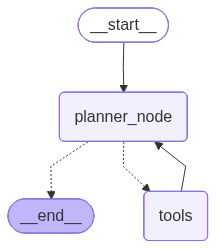

In [25]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
initial_state = {
    "messages": [HumanMessage(content="write a 4 line poem on bengal tiger save first 2 line in tr.txt save the last 2 line in er.txt")]
}

config = {"configurable": {"thread_id": "fqo" ,"user_id": "user_00"}}
# Run the agent
chunk =  graph.invoke(
    initial_state,
    config
)

In [27]:
chunk

{'messages': [HumanMessage(content='write a 4 line poem on bengal tiger save first 2 line in tr.txt save the last 2 line in er.txt', additional_kwargs={}, response_metadata={}, id='f4da81bb-eb48-4806-a168-8cb5c614803f'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'write_file', 'arguments': '{"file_path": "tr.txt", "text": "In stripes of fire, a regal grace,\\nA hunter\'s shadow, in its jungle space."}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': []}, id='run--eaab52e5-1143-4895-8b2d-97761e66e073-0', tool_calls=[{'name': 'write_file', 'args': {'file_path': 'tr.txt', 'text': "In stripes of fire, a regal grace,\nA hunter's shadow, in its jungle space."}, 'id': '497e535b-3b14-4710-a50c-5f39a3ee802a', 'type': 'tool_call'}], usage_metadata={'input_tokens': 2125, 'output_tokens': 103, 'total_tokens': 2228, 'input_token_details': {'cache_read': 0}, 'out

In [28]:
from langgraph.types import Command
user_input = input("Do you accept: ?")

for chunk in graph.stream(
    Command(resume=[{"type": user_input}]),
    config
):
    print(chunk)
    print("\n")

{'tools': {'messages': [ToolMessage(content='File written successfully to tr.txt.', name='write_file', id='83540eb6-726b-489d-b31e-acd416cc9bd1', tool_call_id='497e535b-3b14-4710-a50c-5f39a3ee802a')]}}


{'planner_node': {'messages': AIMessage(content='', additional_kwargs={'function_call': {'name': 'write_file', 'arguments': '{"file_path": "er.txt", "text": "With silent paw, it roams the night,\\nA symbol wild, of fading light."}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': []}, id='run--94e9da49-cbf1-4d3c-ae59-1bca07e5b79a-0', tool_calls=[{'name': 'write_file', 'args': {'file_path': 'er.txt', 'text': 'With silent paw, it roams the night,\nA symbol wild, of fading light.'}, 'id': 'e97a1bb2-3f2f-410a-a76e-e886b4ec9209', 'type': 'tool_call'}], usage_metadata={'input_tokens': 2189, 'output_tokens': 40, 'total_tokens': 2229, 'input_token_details': {'cache_read': 1713}})}}

